Cat Dog Classification
===

In [6]:
import tensorflow as tf
import os
import re
import numpy as np
import zipfile
import matplotlib.pyplot as plt

from tensorflow.contrib.learn.python.learn.estimators import model_fn

slim = tf.contrib.slim

tf.logging.set_verbosity(tf.logging.INFO)

### Utility function
Image reader, Input pipeline, etc.

In [ ]:
CAT = 0
DOG = 1

cwd = os.getcwd()

In [5]:
def prepare_file():
  file_list = ['train', 'test']
  valid = True

  for i in range(len(file_list)):
    filename = file_list[i] + '.zip'
    dest_filename = os.path.join(cwd, 'data', filename)

    if not os.path.exists(dest_filename):
      print('Please download ' + filename + ' and put on src/data folder')
      url = "https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/download/"
      print(url + filename)
      valid = False
      continue
    
    images_path = os.path.join(cwd, 'data', filename)

    zip = zipfile.ZipFile(dest_filename)
    if not os.path.exists(images_path):
        print('Extracting...')
        zip.extractall(os.path.join(cwd, 'data'))
      
  return valid

def read_image_label_list(folder_dir):
    dir_list = os.listdir(os.path.join(cwd, folder_dir))
    
    filenames = []
    labels = []
    
    for i, d in enumerate(dir_list):
        if re.search("train", folder_dir):
            if re.search("cat", d):
                labels.append(CAT)
            else:
                labels.append(DOG)
        else:
            labels.append(-1)
        filenames.append(os.path.join(cwd, folder_dir, d))
    
    return filenames, labels

def read_images_from_disk(input_queue):
    filename = input_queue[0]
    label = input_queue[1]
    
    file_contents = tf.read_file(filename)
    image = tf.image.decode_image(file_contents, channels=3)
    image.set_shape([None, None, 3])
    
    return filename, image, label

def gen_input_fn(image_list, label_list, batch_size, shuffle):
    
    def input_fn():
        images = tf.convert_to_tensor(image_list, dtype=tf.string)
        labels = tf.convert_to_tensor(label_list, dtype=tf.int32)

        input_queue = tf.train.slice_input_producer(
            [images, labels],
            capacity=batch_size * 5,
            shuffle=shuffle,
            name="file_input_queue"
        )

        filename, image, label = read_images_from_disk(input_queue)

        image = tf.image.resize_images(image, (224, 224), tf.image.ResizeMethod.NEAREST_NEIGHBOR)

        filename_batch, image_batch, label_batch = tf.train.batch(
            [filename, image, label],
            batch_size=batch_size,
            num_threads=1,
            name="batch_queue",
            capacity=batch_size * 10,
            allow_smaller_final_batch=False
        )
        
        return (
            filename_batch, 
            tf.identity(image_batch, name="features"), 
            tf.identity(label_batch, name="label")
        )

    return input_fn

def train_valid_input_fn(data_dir, batch_size, shuffle):
    img, labels = read_image_label_list(data_dir)
    img = np.array(img)
    labels = np.array(labels)
    data_size = img.shape[0]

    print("Data size: " + str(data_size))
    split = int(0.7 * data_size)

    random_seq = np.random.permutation(data_size)

    img = img[random_seq]
    labels = labels[random_seq]

    return (
        gen_input_fn(img[0:split], labels[0:split], batch_size, shuffle),
        gen_input_fn(img[split:], labels[split:], batch_size, shuffle)
    )

def test_input_fn(data_dir, batch_size, shuffle):
    image_list, label_list = read_image_label_list(data_dir)
    return gen_input_fn(image_list, label_list, batch_size, shuffle)

### Preview Data
Check correctness of data

In [3]:
if prepare_file():
    print "Files are ready \o/"

Files are ready \o/


Data size: 25000


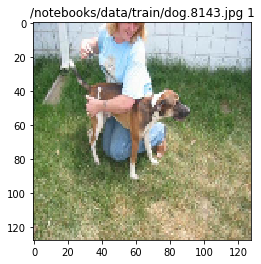

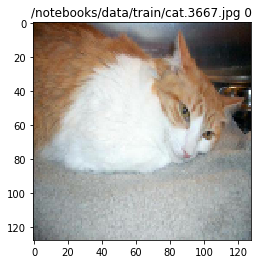

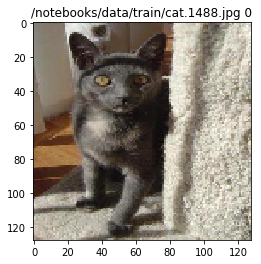

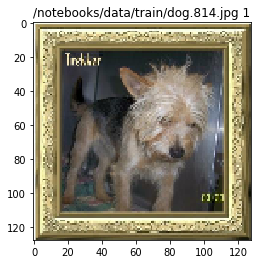

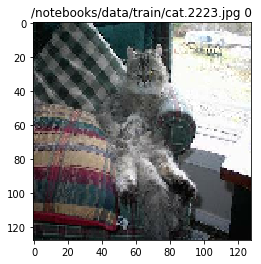

In [4]:
def plot_img(data, label=None):
    plt.ion()
    plt.figure()
    plt.imshow(data)
    if label is not None:
        plt.title(label)

def preview_img():
    
    img_preview = tf.Graph()
    
    with img_preview.as_default():
        tensor_train, _ = train_valid_input_fn('data/train', batch_size=5, shuffle=True)
        result = tf.tuple(tensor_train())
        
    with tf.Session(graph=img_preview) as sess:
        sess.run(tf.local_variables_initializer())
        sess.run(tf.global_variables_initializer())
        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(coord=coord)

        filenames, images, labels = sess.run(result)
        for i in range(len(images)):
            plot_img(images[i], filenames[i] + " " + str(labels[i]))

        coord.request_stop()
        coord.join(threads)

        sess.close()

preview_img()

### Define Model
Create a VGG19 model for using in Estimator

In [ ]:
def vgg_19(inputs, is_training):
    with tf.variable_scope('vgg_19', values=[inputs]):
        with slim.arg_scope(
            [slim.conv2d, slim.fully_connected],
            activation_fn=tf.nn.relu,
            weights_initializer=tf.truncated_normal_initializer(0.0, 0.01),
            weights_regularizer=slim.l2_regularizer(0.0005)):
        
            net = slim.repeat(inputs, 2, slim.conv2d, 64, [3, 3], scope='conv1')
            net = slim.max_pool2d(net, [2, 2], scope='pool1')

            net = slim.repeat(net, 2, slim.conv2d, 128, [3, 3], scope='conv2')
            net = slim.max_pool2d(net, [2, 2], scope='pool2')

            net = slim.repeat(net, 4, slim.conv2d, 256, [3, 3], scope='conv3')
            net = slim.max_pool2d(net, [2, 2], scope='pool3')
            net = slim.repeat(net, 4, slim.conv2d, 512, [3, 3], scope='conv4')
            net = slim.max_pool2d(net, [2, 2], scope='pool4')
            net = slim.repeat(net, 4, slim.conv2d, 512, [3, 3], scope='conv5')
            net = slim.max_pool2d(net, [2, 2], scope='pool5')

            net = slim.fully_connected(net, 4096, [7, 7], scope='fc6')
            net = slim.dropout(net, 0.5, is_training=is_training, scope='dropout6')

            net = slim.fully_connected(net, 4096, [1, 1], scope='fc7')
            net = slim.dropout(net, 0.5, is_training=is_training, scope='dropout7')

            net = slim.fully_connected(net, 2, activation_fn=None, scope='fc8')
            
            return net

In [ ]:
def vgg_model_fn(features, labels, mode, params):
    
    is_training = False
    if mode == learn.ModeKeys.TRAIN:
        is_training = True
        
    logits = vgg_19(features, is_training)
    
    loss = None
    train_op = None
    
    if mode != learn.ModeKeys.INFER:
        onehot_labels = tf.one_hot(
            tf.cast(labels, tf.int32), 
            depth = 2
        )
        loss = slim.losses.softmax_cross_entropy(
            predictions,
            onehot_labels
        )
        
    if mode == learn.ModeKeys.TRAIN:
        train_op = slim.learning.create_train_op(
            loss,
            tf.train.AdamOptimizer(
                learning_rate = params['learning_rate']
            )
        )
    
    prediction = {
        "classes": tf.argmax(logits, axis = 1),
        "probabilities": tf.nn.softmax(logits)
    }
    
    return model_fn.ModelFnOps(
        mode = mode,
        predictions = predictions,
        loss = loss,
        train_op = train_op
    )
    
        
    
        